## 1. Introduction

This notebook is to perform preprocessing, modeling and hyperparameter tuning for the churn prediction problem at ABC Bank. The previous noteboo on EDA looked at relationships between different variables and customer churn. The key takeaways were:

1. France has twice as many customers, but the number of customers who churn is similar to Germany and Spain. So, customers in Germany and Spain have a higher risk of churning
2. The median age of churners is a little bit higher than those who do not churn
3. Members who are active are less likely to churn
4. Only 20% of the customers churned. So, there is imbalance in the dataset as there is 80% of one class and 20% of the other
5. Number of products and Age seem to have the highest correlation while Activness, Balance and tenure have moderate correlation with customer churn.¶
6. Balance has good correlation with geography and number of products

## 2. Imports

In [3]:
#Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score
from sklearn.metrics import classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

C:\Users\krven\anaconda3\lib\site-packages\dask\config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
#importing data
churn_data=pd.read_csv("../raw data/Churn_data.csv")

In [5]:
#Printing first 5 rows:
churn_data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [6]:
#Dropping unwanted rows: Row number, Customer ID and Surname
churn_data.drop(['RowNumber', 'CustomerId', 'Surname'],axis=1,inplace=True)
churn_data.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

In [7]:
#Checking the data types
churn_data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## Creating dummy variables for categorical columns

In [8]:
#Creating dummy variables so that the algorithm can understand the features and dropping first to ensure there is no multicollinearity
churn_data=pd.get_dummies(churn_data,columns=["Geography","Gender"],drop_first=True)
churn_data.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42       2       0.00              1          1   
1          608   41       1   83807.86              1          0   
2          502   42       8  159660.80              3          1   
3          699   39       1       0.00              2          0   
4          850   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0               1        101348.88       1                  0   
1               1        112542.58       0                  0   
2               0        113931.57       1                  0   
3               0         93826.63       0                  0   
4               1         79084.10       0                  0   

   Geography_Spain  Gender_Male  
0                0            0  
1                1            0  
2                0            0  
3                0            0  
4                1            0

## Splitting the dataset to get X and y

In [9]:
X=churn_data.drop(["Exited"],axis=1)
y=churn_data["Exited"]
print(X.shape,y.shape)

(10000, 11) (10000,)


## Splitting the dataset into training and testing

In [10]:
#Splitting into train and  test and stratify based on y so that tht proportion of churn is same in train and test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y, random_state=1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(8000, 11) (8000,) (2000, 11) (2000,)


## Standardizing the dataset

In [11]:
#The next step is to standardizethe features so that they are all in the same range
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train) # fits to training mean and standard deviation and also transforms it
X_test=scaler.transform(X_test)

## KNN Classifier

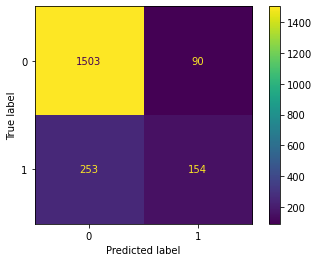

In [12]:
#Fitting the default KNN classifier
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_train)
y_pred=knn_clf.predict(X_test)
plot_confusion_matrix(knn_clf, X_test, y_test,values_format='d')  
plt.show() 

In [13]:
#Model evaluation using various metrics
test_prob = knn_clf.predict_proba(X_test)[:, 1]

#print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
#print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
#print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

Average Precision = 0.47538

Using 0.5 as threshold:
Precision = 0.63115
Recall = 0.37838
F1 score = 0.47312


## KNN Classifier - Hyperparameter tuning

In [14]:
hyperparamter_grid={"n_neighbors":[1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,75,100,200,500],
                   'weights':['uniform','distance'],
                   'leaf_size':[5,10,15,20,25,30,40,50,60,75],
                   'p':[1,2]}

In [23]:
knn_clf_rand=RandomizedSearchCV(KNeighborsClassifier(),hyperparamter_grid,scoring=["precision","recall","f1_macro"],n_iter=1000, cv=10, n_jobs=-1, refit="f1_macro")
knn_clf_rand.fit(X_train,y_train)
print(f'Best score: {knn_clf_rand.best_score_} with param: {knn_clf_rand.best_params_}')

C:\Users\krven\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 800 is smaller than n_iter=1000. Running 800 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best score: 0.6965000296136539 with param: {'weights': 'distance', 'p': 1, 'n_neighbors': 4, 'leaf_size': 5}


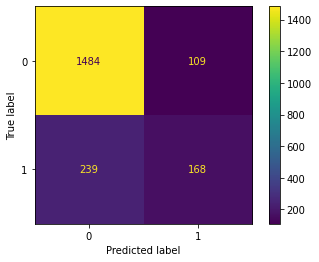

In [24]:
y_pred=knn_clf_rand.predict(X_test)
plot_confusion_matrix(knn_clf_rand, X_test, y_test,values_format='d')  
plt.show() 

In [25]:
#Model evaluation using various metrics
test_prob = knn_clf_rand.predict_proba(X_test)[:, 1]

#print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
#print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
#print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

Average Precision = 0.52070

Using 0.5 as threshold:
Precision = 0.60650
Recall = 0.41278
F1 score = 0.49123


## Default Logistic Regression

In [10]:
## Fitting a classifier
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
y_pred=clf.predict(X_test)

from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score
from sklearn.metrics import classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix

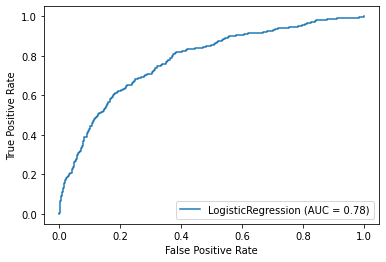

In [12]:
plot_roc_curve(clf,X_test,y_test)

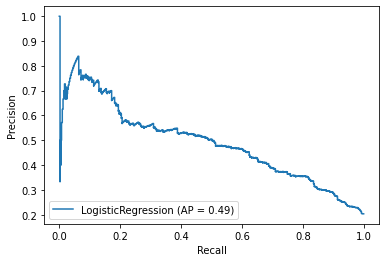

In [13]:
plot_precision_recall_curve(clf, X_test, y_test)

In [21]:
#Model evaluation using various metrics
test_prob = clf.predict_proba(X_test)[:, 1]

#print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
#print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
#print('Accuracy = {:.5f}'.format(accuracy_score(y_test, y_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

print('\nClassification Report')
print(classification_report(y_test, y_pred))

Average Precision = 0.48995

Using 0.5 as threshold:
Precision = 0.59286
Recall = 0.20393
F1 score = 0.30347

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1593
           1       0.59      0.20      0.30       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.60      2000
weighted avg       0.78      0.81      0.77      2000



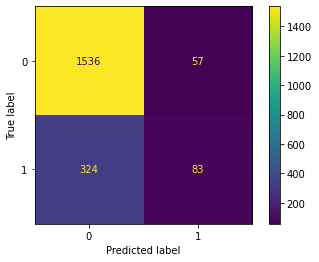

In [28]:
plot_confusion_matrix(clf, X_test, y_test,values_format='d')  
plt.show() 

### The general logistic regression model does a poor job in identifying the customers who will churn and predicts a lot of customers who churn as not churn. This is not what we want.

#https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
#https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
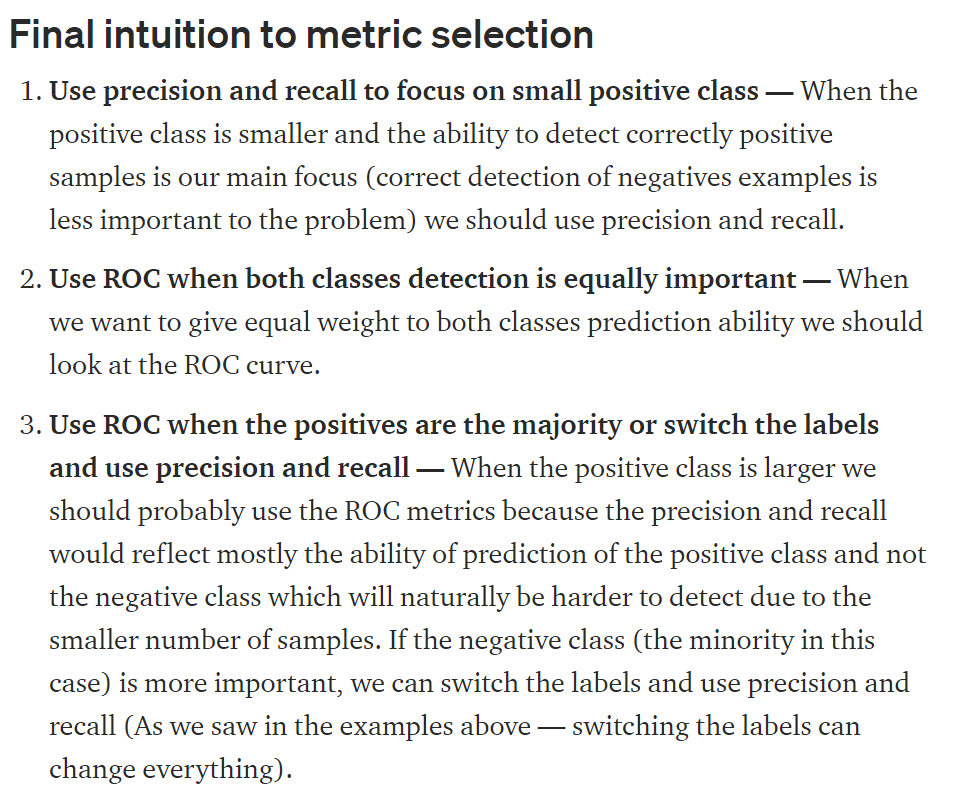

In [ ]:
#perform resamling and weighted logistic regression.
#perform random forest, xgboost, nueral network

### Because there is imbalance in the number of customers churned and the critical class has fewer samples, it is time to use weighted logistic regression

In [22]:
#Trial with "Balanced" Logistic regression
clf2 = LogisticRegression(random_state=0,class_weight="balanced")
clf2.fit(X_train, y_train)
y_pred=clf2.predict(X_test)

In [23]:
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

print('\nClassification Report')
print(classification_report(y_test, y_pred))

Average Precision = 0.48995

Using 0.5 as threshold:
Precision = 0.39171
Recall = 0.71990
F1 score = 0.50736

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1593
           1       0.39      0.72      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.80      0.72      0.74      2000



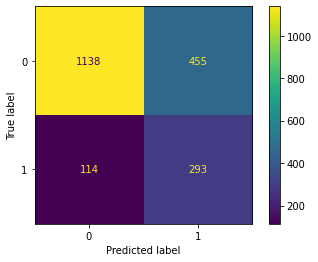

In [27]:
plot_confusion_matrix(clf2, X_test, y_test,values_format='d')
plt.show()

The balanced model is predicting a lot more customers as churned and thus the precision is lower. But the recall and F1 score hare greater than the previous model.

Importantly, the number of False Negatives has reduced.

Now, let us try different weights to further reduce improve the model

In [44]:
#https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
# define hyperparameters
w = ["balanced",{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }

In [45]:
# logistic model classifier
clf2 = LogisticRegression(random_state=1)
# define evaluation procedure
search = RandomizedSearchCV(clf2,hyperparam_grid,scoring=["precision","recall","f1"], cv=100, n_jobs=-1, refit="f1")
search.fit(X_train,y_train)
print(f'Best score: {search.best_score_} with param: {search.best_params_}')

Best score: 0.4725115639101501 with param: {'penalty': 'l2', 'fit_intercept': False, 'class_weight': {0: 10, 1: 0.1}, 'C': 14.0}


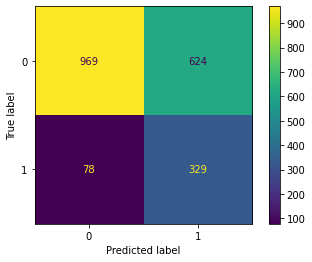

In [80]:
plot_confusion_matrix(search, X_test, y_test,values_format='d')
plt.show()

In [26]:
#https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
# define hyperparameters
w = ["balanced",{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }

In [27]:
# logistic model classifier
clf2 = LogisticRegression(random_state=1)
# define evaluation procedure
search = RandomizedSearchCV(clf2,hyperparam_grid,scoring=["precision","recall","f1"], cv=100, n_jobs=-1, refit="f1")
search.fit(X_train,y_train)
print(f'Best score: {search.best_score_} with param: {search.best_params_}')

Best score: 0.4764181245954646 with param: {'penalty': 'l2', 'fit_intercept': False, 'class_weight': {0: 100, 1: 1000}, 'C': 6.0}


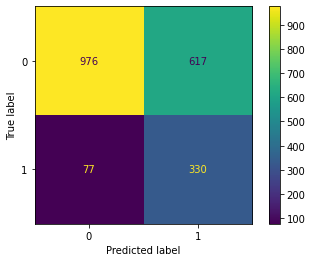

In [28]:
plot_confusion_matrix(search, X_test, y_test,values_format='d')
plt.show()

In [30]:
y_pred=search.predict(X_test)
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

print('\nClassification Report')
print(classification_report(y_test, y_pred))

Average Precision = 0.52070

Using 0.5 as threshold:
Precision = 0.34847
Recall = 0.81081
F1 score = 0.48744

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      1593
           1       0.35      0.81      0.49       407

    accuracy                           0.65      2000
   macro avg       0.64      0.71      0.61      2000
weighted avg       0.81      0.65      0.69      2000



In [208]:
#https://towardsdatascience.com/weighted-logistic-regression-for-imbalanced-dataset-9a5cd88e68b
# define hyperparameters
w = ["balanced",{0:0.1,1:0.9},{0:0.2,1:0.8}, {0:0.3,1:0.7}, 
     {0:0.4,1:0.6}, {0:0.5,1:0.5}, {0:0.6,1:0.4}, {0:0.7,1:0.3},
    {0:0.8,1:0.2}, {0:0.9,1:0.1},{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0.5, 20.0, 0.5)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]  }

In [209]:
# logistic model classifier
clf2 = LogisticRegression()
# define evaluation procedure
search2 = RandomizedSearchCV(clf2,hyperparam_grid,scoring=["f1","precision","recall"],n_iter=500, cv=100, n_jobs=-1, refit="f1")
search2.fit(X_train,y_train)
print(f'Best score: {search2.best_score_} with param: {search2.best_params_}')

Best score: 0.4935218048754138 with param: {'penalty': 'l2', 'fit_intercept': True, 'class_weight': 'balanced', 'C': 18.5}


In [210]:
y_pred=search2.predict(X_test)

In [211]:
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

print('\nClassification Report')
print(classification_report(y_test, y_pred))

Average Precision = 0.48995

Using 0.5 as threshold:
Precision = 0.39171
Recall = 0.71990
F1 score = 0.50736

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1593
           1       0.39      0.72      0.51       407

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.80      0.72      0.74      2000



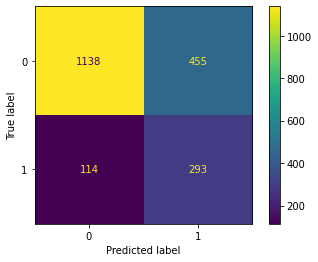

In [212]:
plot_confusion_matrix(search2, X_test, y_test,values_format='d')
plt.show()

In [213]:
search2.best_estimator_.coef_[0]

array([-0.05048022,  0.8192417 , -0.03221045,  0.15555588, -0.04172922,
       -0.01350291, -0.45716246,  0.02780081,  0.34727632,  0.04309777,
       -0.27595961])

In [214]:
x=churn_data.drop("Exited",axis=1)
x.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [215]:
coefficients_logistic=pd.DataFrame({"feature":x.columns,"coefficient":search2.best_estimator_.coef_[0]})
coefficients_logistic

feature  coefficient
0         CreditScore    -0.050480
1                 Age     0.819242
2              Tenure    -0.032210
3             Balance     0.155556
4       NumOfProducts    -0.041729
5           HasCrCard    -0.013503
6      IsActiveMember    -0.457162
7     EstimatedSalary     0.027801
8   Geography_Germany     0.347276
9     Geography_Spain     0.043098
10        Gender_Male    -0.275960

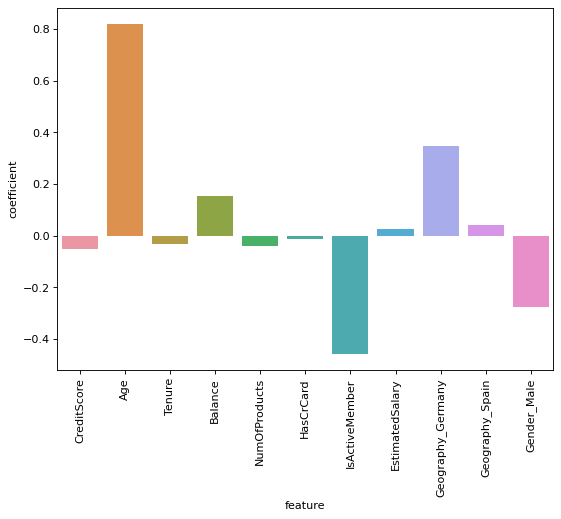

In [216]:
figure(figsize=(8, 6), dpi=80)
sns.barplot(data=coefficients_logistic,x="feature",y="coefficient")
plt.xticks(rotation=90)
plt.show()

## Random forest classifier

In [196]:
#Defining the hyperparmater space for random forest
w = [None,"balanced",{0:0.1,1:0.9},{0:0.2,1:0.8}, {0:0.3,1:0.7}, 
     {0:0.4,1:0.6}, {0:0.5,1:0.5}]
hyperparamter_grid={"n_estimators":[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
                   "criterion":["gini", "entropy"],
                   "max_depth":[1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
                   "max_features":["auto", "sqrt", "log2"],
                   "class_weight":w,
                   "bootstrap":[True,False]}

In [203]:
#Fiting the random forest through randomized search
rand_clf=RandomForestClassifier()
rand_search=RandomizedSearchCV(rand_clf,hyperparamter_grid,scoring=["f1","precision","recall"],n_iter=50, cv=25, n_jobs=-1, refit="f1")
rand_search.fit(X_train,y_train)
print(f'Best score: {rand_search.best_score_} with param: {rand_search.best_params_}')

Best score: 0.620806638162104 with param: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini', 'class_weight': {0: 0.3, 1: 0.7}, 'bootstrap': True}


In [204]:
y_pred=rand_search.predict(X_test)

In [205]:
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

print('\nClassification Report')
print(classification_report(y_test, y_pred))

Average Precision = 0.48995

Using 0.5 as threshold:
Precision = 0.69677
Recall = 0.53071
F1 score = 0.60251

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1593
           1       0.70      0.53      0.60       407

    accuracy                           0.86      2000
   macro avg       0.79      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



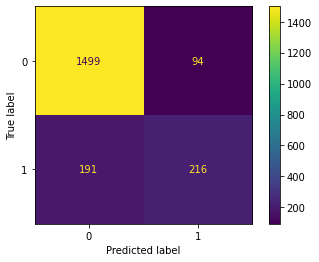

In [206]:
plot_confusion_matrix(rand_search, X_test, y_test,values_format='d')
plt.show()

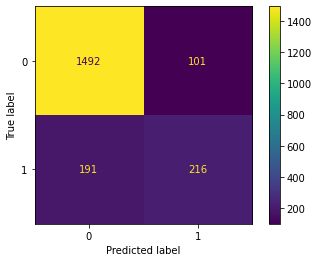

In [217]:
best_rand_forest=RandomForestClassifier(n_estimators= 200, max_features='log2', max_depth= 10, criterion='gini', class_weight= {0: 0.3, 1: 0.7}, bootstrap= True)
best_rand_forest.fit(X_train,y_train)
y_pred=best_rand_forest.predict(X_test)
plot_confusion_matrix(best_rand_forest, X_test, y_test,values_format='d')
plt.show()

In [220]:
estimator = best_rand_forest.estimators_[5]

In [222]:


from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = x.columns,
                class_names = ["0","1"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## XGBoost Classifier

In [241]:
# A parameter grid for XGBoost
w = [None,"balanced",{0:0.1,1:0.9},{0:0.2,1:0.8}, {0:0.3,1:0.7}, 
     {0:0.4,1:0.6}, {0:0.5,1:0.5}]
params = {"n_estimators":[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.25, 0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'class_weight':w,
          'max_depth': [1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
          'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3]
         }

In [242]:
xgb_clf = XGBClassifier(objective='binary:logistic',nthread=-1)
xgb_search=RandomizedSearchCV(xgb_clf,hyperparamter_grid,scoring=["f1","precision","recall"],n_iter=1000, cv=5, n_jobs=-1, refit="f1")
xgb_search.fit(X_train,y_train)
print(f'Best score: {xgb_search.best_score_} with param: {xgb_search.best_params_}')

C:\Users\krven\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:55:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, class_weight, criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:55:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.596824196160361 with param: {'n_estimators': 100, 'max_features': 'log2', 'max_depth': 3, 'criterion': 'gini', 'class_weight': {0: 0.4, 1: 0.6}, 'bootstrap': True}


In [243]:
y_pred=xgb_search.predict(X_test)

In [244]:
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Precision = {:.5f}'.format(precision_score(y_test, y_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, y_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, y_pred)))

print('\nClassification Report')
print(classification_report(y_test, y_pred))

Average Precision = 0.48995

Using 0.5 as threshold:
Precision = 0.78629
Recall = 0.47912
F1 score = 0.59542

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.79      0.48      0.60       407

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000



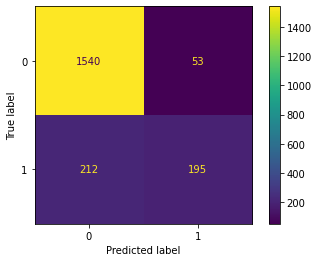

In [245]:
plot_confusion_matrix(xgb_search, X_test, y_test,values_format='d')
plt.show()